In [12]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Language classes
target_classes = ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam',
                  'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu']

base_folder = '/home/teaching/Downloads/dataset/Language Detection Dataset'
output_folder = '/home/teaching/Downloads/Feature Engineering'

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Loop over each language class
for target_class in target_classes:
    print(f"\nProcessing: {target_class}")
    folder_path = os.path.join(base_folder, target_class)

    # Get all eligible audio files and sample 2000 randomly
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.mp3') or f.endswith('.wav')]
    sampled_files = random.sample(all_files, min(2000, len(all_files)))

    features = []

    for filename in sampled_files:
        file_path = os.path.join(folder_path, filename)
        try:
            y, sr = librosa.load(file_path, sr=16000)

            # Extract features
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
            pitch, _ = librosa.piptrack(y=y, sr=sr)
            pitch_mean = pitch[pitch > 0].mean() if np.any(pitch > 0) else 0
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

            feat_vector = np.concatenate([mfccs, [pitch_mean, zcr, centroid]])
            features.append(feat_vector)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Convert to NumPy
    features = np.array(features)
    if features.shape[0] < 2:
        print(f"Not enough data to perform PCA for {target_class}")
        continue

    # Apply PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1])
    plt.title(f'PCA of Audio Features - {target_class}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)

    # Save plot
    save_path = os.path.join(output_folder, f'{target_class}_pca.png')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

    print(f"Saved PCA plot to {save_path}")



Processing: Bengali


/home/teaching/miniconda3/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=976
  warnings.warn(
/home/teaching/miniconda3/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=208
  warnings.warn(


Saved PCA plot to /home/teaching/Downloads/Feature Engineering/Bengali_pca.png

Processing: Gujarati


/home/teaching/miniconda3/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1423
  warnings.warn(


Saved PCA plot to /home/teaching/Downloads/Feature Engineering/Gujarati_pca.png

Processing: Hindi
Saved PCA plot to /home/teaching/Downloads/Feature Engineering/Hindi_pca.png

Processing: Kannada
Saved PCA plot to /home/teaching/Downloads/Feature Engineering/Kannada_pca.png

Processing: Malayalam
Saved PCA plot to /home/teaching/Downloads/Feature Engineering/Malayalam_pca.png

Processing: Marathi
Saved PCA plot to /home/teaching/Downloads/Feature Engineering/Marathi_pca.png

Processing: Punjabi
Saved PCA plot to /home/teaching/Downloads/Feature Engineering/Punjabi_pca.png

Processing: Tamil


/home/teaching/miniconda3/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=494
  warnings.warn(


Saved PCA plot to /home/teaching/Downloads/Feature Engineering/Tamil_pca.png

Processing: Telugu
Saved PCA plot to /home/teaching/Downloads/Feature Engineering/Telugu_pca.png

Processing: Urdu
Saved PCA plot to /home/teaching/Downloads/Feature Engineering/Urdu_pca.png


In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm import tqdm
import random

# === PARAMETERS ===
target_classes = ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam',
                  'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu']
base_folder = '/home/teaching/Downloads/dataset/Language Detection Dataset'
max_files_per_class = 1000  # Random 1000 files

# === FEATURE EXTRACTION ===
features = []
labels = []

for target_class in target_classes:
    folder_path = os.path.join(base_folder, target_class)
    print(f"Processing: {target_class}")

    all_files = [f for f in os.listdir(folder_path) if f.endswith('.mp3') or f.endswith('.wav')]
    selected_files = random.sample(all_files, min(len(all_files), max_files_per_class))

    for filename in tqdm(selected_files):
        file_path = os.path.join(folder_path, filename)
        try:
            y, sr = librosa.load(file_path, sr=16000)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
            pitch, _ = librosa.piptrack(y=y, sr=sr)
            pitch_mean = pitch[pitch > 0].mean() if np.any(pitch > 0) else 0
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

            feat_vector = np.concatenate([mfccs, [pitch_mean, zcr, centroid]])
            features.append(feat_vector)
            labels.append(target_class)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# === DATAFRAME PREPARATION ===
feature_names = [f'MFCC_{i+1}' for i in range(13)] + ['Pitch', 'ZCR', 'Centroid']
df = pd.DataFrame(features, columns=feature_names)
df['Language'] = labels

# === COMPUTE MEAN FEATURE VECTOR PER LANGUAGE ===
mean_vectors = df.groupby('Language').mean()

# === COMPARE LANGUAGE PAIRS ===
comparison_results = {}

for lang1, lang2 in combinations(target_classes, 2):
    vec1 = mean_vectors.loc[lang1]
    vec2 = mean_vectors.loc[lang2]
    abs_diff = (vec1 - vec2).abs()
    sorted_diff = abs_diff.sort_values(ascending=False)
    comparison_results[(lang1, lang2)] = sorted_diff.head(5)

# === PRINT RESULTS ===
for pair, features_diff in comparison_results.items():
    print(f"\nTop distinguishing features between {pair[0]} and {pair[1]}:")
    print(features_diff)


Processing: Bengali


100%|██████████| 1000/1000 [00:21<00:00, 45.57it/s]


Processing: Gujarati


 49%|████▊     | 486/1000 [00:09<00:10, 49.62it/s]/home/teaching/miniconda3/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=262
  warnings.warn(
100%|██████████| 1000/1000 [00:20<00:00, 49.20it/s]


Processing: Hindi


100%|██████████| 1000/1000 [00:20<00:00, 48.30it/s]


Processing: Kannada


100%|██████████| 1000/1000 [00:19<00:00, 52.09it/s]


Processing: Malayalam


100%|██████████| 1000/1000 [00:19<00:00, 50.35it/s]


Processing: Marathi


100%|██████████| 1000/1000 [00:20<00:00, 48.43it/s]


Processing: Punjabi


100%|██████████| 1000/1000 [00:20<00:00, 49.02it/s]


Processing: Tamil


 33%|███▎      | 332/1000 [00:06<00:13, 49.49it/s]/home/teaching/miniconda3/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=494
  warnings.warn(
100%|██████████| 1000/1000 [00:20<00:00, 49.67it/s]


Processing: Telugu


100%|██████████| 1000/1000 [00:20<00:00, 48.64it/s]


Processing: Urdu


100%|██████████| 1000/1000 [00:20<00:00, 49.08it/s]



Top distinguishing features between Bengali and Gujarati:
Pitch       155.186126
Centroid     62.414009
MFCC_1       47.559711
MFCC_3       32.882064
MFCC_6        9.716980
dtype: float64

Top distinguishing features between Bengali and Hindi:
Centroid    491.787043
Pitch       163.736506
MFCC_2       27.377913
MFCC_1       16.411867
MFCC_7        7.257454
dtype: float64

Top distinguishing features between Bengali and Kannada:
Centroid    499.309383
Pitch       417.907154
MFCC_3       78.930833
MFCC_1       44.028845
MFCC_5       43.389073
dtype: float64

Top distinguishing features between Bengali and Malayalam:
Centroid    135.643294
MFCC_6       20.464333
MFCC_7       14.100204
MFCC_5       13.457117
MFCC_2       12.297437
dtype: float64

Top distinguishing features between Bengali and Marathi:
MFCC_1      34.775106
Centroid    28.372845
Pitch       27.362889
MFCC_3      15.212385
MFCC_2      12.586527
dtype: float64

Top distinguishing features between Bengali and Punjabi:
Pitch 

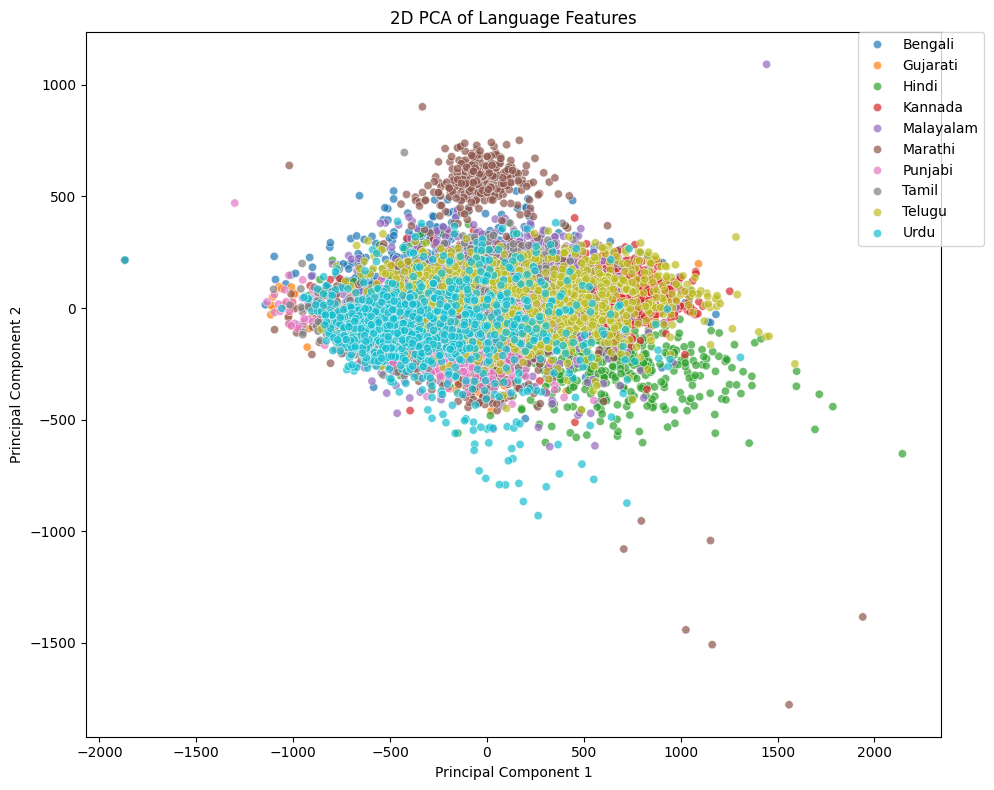

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2D using PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(df[feature_names])

# Add to DataFrame for plotting
df['PC1'] = features_2d[:, 0]
df['PC2'] = features_2d[:, 1]

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Language', palette='tab10', alpha=0.7)
plt.title('2D PCA of Language Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.tight_layout()
plt.show()


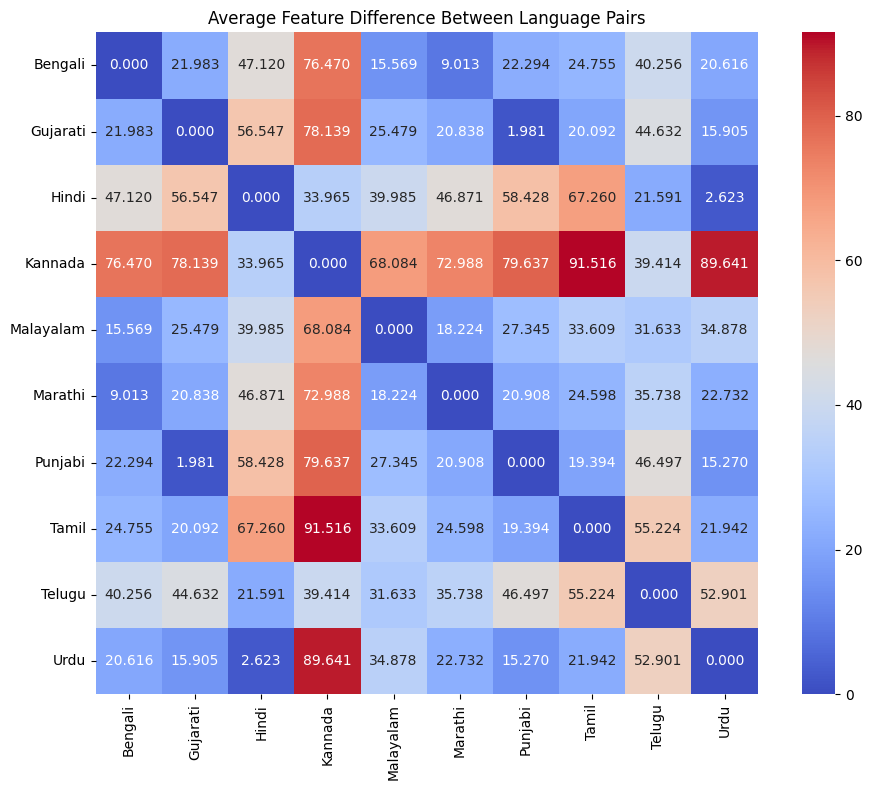

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === TABLE OF TOP DISTINGUISHING FEATURES ===
table_data = []
for (lang1, lang2), features_diff in comparison_results.items():
    for feature, diff_value in features_diff.items():
        table_data.append({
            'Language 1': lang1,
            'Language 2': lang2,
            'Feature': feature,
            'Difference': diff_value
        })

comparison_df = pd.DataFrame(table_data)

# Save to CSV for inspection
comparison_df.to_csv("language_feature_differences.csv", index=False)

# === HEATMAP OF AVERAGE DIFFERENCE BETWEEN LANGUAGE PAIRS ===
# Compute average absolute difference over all features for each pair
pair_diff_matrix = pd.DataFrame(0.0, index=target_classes, columns=target_classes)

for (lang1, lang2), features_diff in comparison_results.items():
    vec1 = mean_vectors.loc[lang1]
    vec2 = mean_vectors.loc[lang2]
    avg_diff = (vec1 - vec2).abs().mean()
    pair_diff_matrix.loc[lang1, lang2] = avg_diff
    pair_diff_matrix.loc[lang2, lang1] = avg_diff  # symmetric


plt.figure(figsize=(10, 8))
sns.heatmap(pair_diff_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True)
plt.title("Average Feature Difference Between Language Pairs")
plt.tight_layout()
plt.savefig("language_pair_difference_heatmap.png")
plt.show()


In [31]:
# Flatten the matrix and filter out self-pairs (diagonal)
sorted_pairs = []

for lang1 in target_classes:
    for lang2 in target_classes:
        if lang1 != lang2:
            diff = pair_diff_matrix.loc[lang1, lang2]
            sorted_pairs.append((lang1, lang2, diff))

# Sort by the lowest average feature difference
sorted_pairs = sorted(sorted_pairs, key=lambda x: x[2])

# Print the top 5 most similar pairs
print("Top 5 most similar language pairs based on feature vectors:")
for i in range(5):
    lang1, lang2, diff = sorted_pairs[i]
    print(f"{i+1}. {lang1} & {lang2} - Average feature difference: {diff:.4f}")


Top 5 most similar language pairs based on feature vectors:
1. Gujarati & Punjabi - Average feature difference: 1.1278
2. Punjabi & Gujarati - Average feature difference: 1.1278
3. Bengali & Marathi - Average feature difference: 9.5199
4. Marathi & Bengali - Average feature difference: 9.5199
5. Bengali & Malayalam - Average feature difference: 15.8257


Processing: Bengali


 80%|████████  | 800/1000 [00:16<00:04, 47.97it/s]/home/teaching/miniconda3/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=976
  warnings.warn(
100%|██████████| 1000/1000 [00:20<00:00, 48.13it/s]


Processing: Gujarati


 30%|███       | 303/1000 [00:06<00:14, 49.29it/s]/home/teaching/miniconda3/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=799
  warnings.warn(
100%|██████████| 1000/1000 [00:20<00:00, 48.72it/s]


Processing: Hindi


100%|██████████| 1000/1000 [00:20<00:00, 48.16it/s]


Processing: Kannada


100%|██████████| 1000/1000 [00:19<00:00, 52.39it/s]


Processing: Malayalam


 10%|▉         | 97/1000 [00:01<00:17, 50.67it/s]/home/teaching/miniconda3/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1621
  warnings.warn(
 12%|█▏        | 121/1000 [00:02<00:16, 52.02it/s]/home/teaching/miniconda3/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=262
  warnings.warn(
100%|██████████| 1000/1000 [00:19<00:00, 51.11it/s]


Processing: Marathi


100%|██████████| 1000/1000 [00:20<00:00, 48.18it/s]


Processing: Punjabi


100%|██████████| 1000/1000 [00:20<00:00, 49.10it/s]


Processing: Tamil


100%|██████████| 1000/1000 [00:20<00:00, 49.69it/s]


Processing: Telugu


100%|██████████| 1000/1000 [00:20<00:00, 48.44it/s]


Processing: Urdu


100%|██████████| 1000/1000 [00:20<00:00, 48.29it/s]


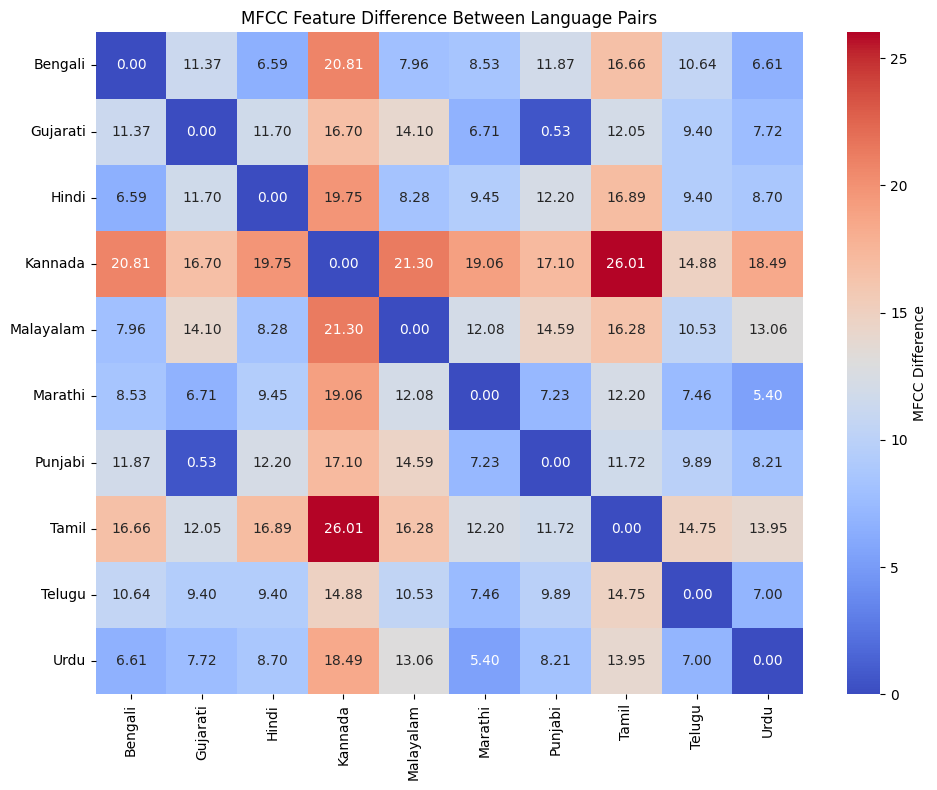

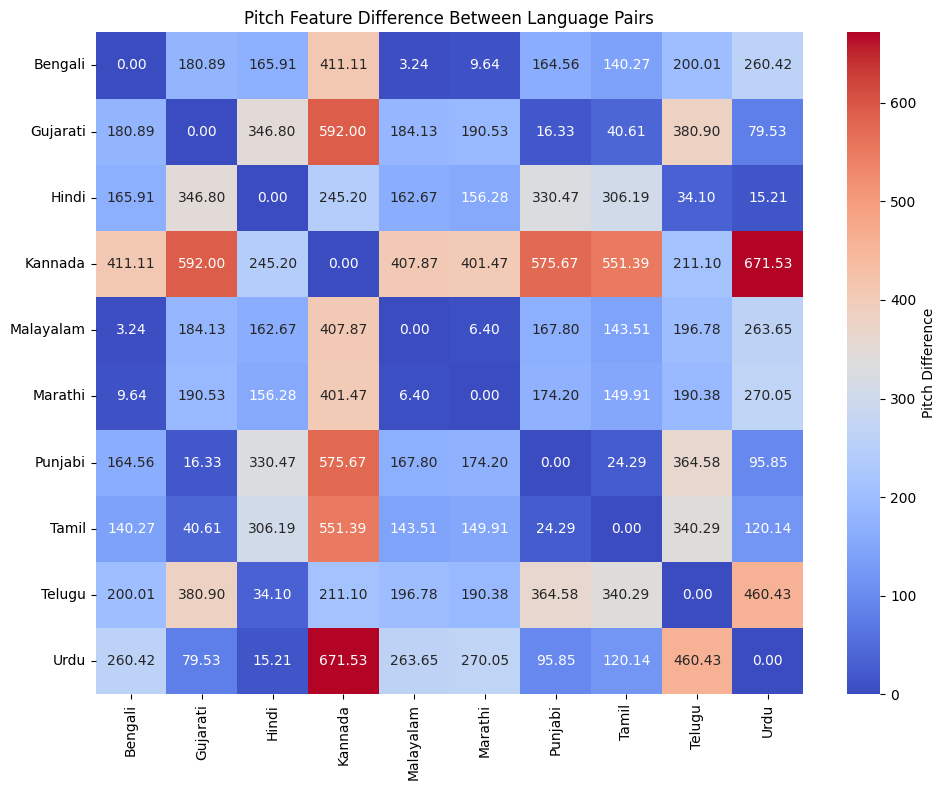

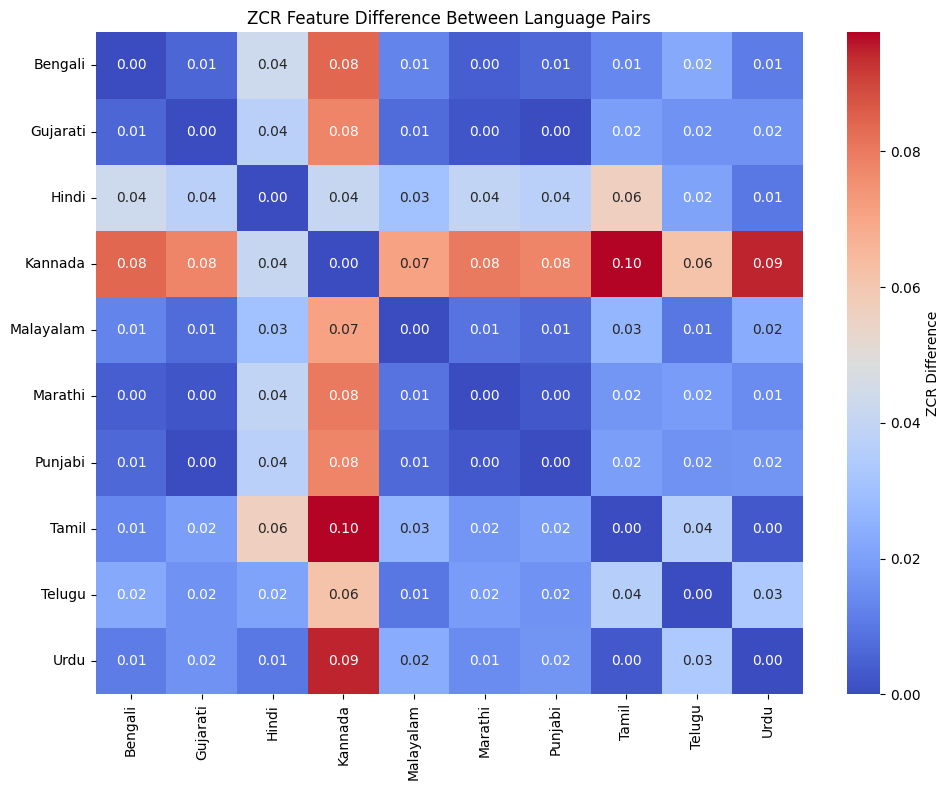

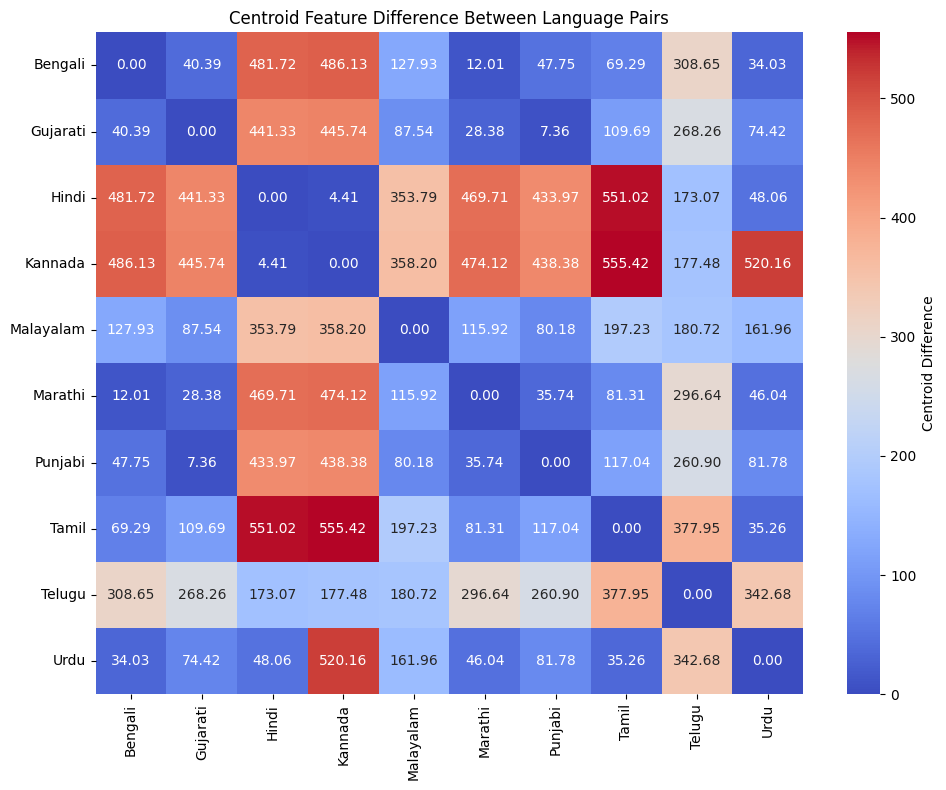

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt

# === PARAMETERS ===
target_classes = ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam',
                  'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu']
base_folder = '/home/teaching/Downloads/dataset/Language Detection Dataset'
max_files_per_class = 1000  # Random 1000 files

# === FEATURE EXTRACTION ===
features = []
labels = []

for target_class in target_classes:
    folder_path = os.path.join(base_folder, target_class)
    print(f"Processing: {target_class}")

    all_files = [f for f in os.listdir(folder_path) if f.endswith('.mp3') or f.endswith('.wav')]
    selected_files = random.sample(all_files, min(len(all_files), max_files_per_class))

    for filename in tqdm(selected_files):
        file_path = os.path.join(folder_path, filename)
        try:
            y, sr = librosa.load(file_path, sr=16000)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
            pitch, _ = librosa.piptrack(y=y, sr=sr)
            pitch_mean = pitch[pitch > 0].mean() if np.any(pitch > 0) else 0
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

            feat_vector = np.concatenate([mfccs, [pitch_mean, zcr, centroid]])
            features.append(feat_vector)
            labels.append(target_class)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# === DATAFRAME PREPARATION ===
feature_names = [f'MFCC_{i+1}' for i in range(13)] + ['Pitch', 'ZCR', 'Centroid']
df = pd.DataFrame(features, columns=feature_names)
df['Language'] = labels

# === COMPUTE MEAN FEATURE VECTOR PER LANGUAGE ===
mean_vectors = df.groupby('Language').mean()

# === COMPUTE FEATURE-WISE AVERAGE DIFFERENCES ===
feature_wise_results = {}

# Compute differences for each individual feature
for lang1, lang2 in combinations(target_classes, 2):
    vec1 = mean_vectors.loc[lang1]
    vec2 = mean_vectors.loc[lang2]

    # Difference for MFCCs (13 coefficients)
    mfcc_diff = (vec1[:13] - vec2[:13]).abs().mean()
    
    # Difference for Pitch
    pitch_diff = np.abs((vec1['Pitch'] - vec2['Pitch']))
    
    # Difference for ZCR
    zcr_diff =np.abs( (vec1['ZCR'] - vec2['ZCR']))
    
    # Difference for Centroid
    centroid_diff = np.abs((vec1['Centroid'] - vec2['Centroid']))

    # Store the feature-wise differences
    feature_wise_results[(lang1, lang2)] = {
        'MFCC_diff': mfcc_diff,
        'Pitch_diff': pitch_diff,
        'ZCR_diff': zcr_diff,
        'Centroid_diff': centroid_diff
    }

# === CREATE A COMPARISON MATRIX FOR EACH FEATURE ===
# Initialize matrices for each feature
feature_matrix_mfcc = pd.DataFrame(np.zeros((len(target_classes), len(target_classes))),
                                   index=target_classes, columns=target_classes)
feature_matrix_pitch = pd.DataFrame(np.zeros((len(target_classes), len(target_classes))),
                                    index=target_classes, columns=target_classes)
feature_matrix_zcr = pd.DataFrame(np.zeros((len(target_classes), len(target_classes))),
                                  index=target_classes, columns=target_classes)
feature_matrix_centroid = pd.DataFrame(np.zeros((len(target_classes), len(target_classes))),
                                       index=target_classes, columns=target_classes)

# Fill in the matrices with differences
for (lang1, lang2), diffs in feature_wise_results.items():
    feature_matrix_mfcc.loc[lang1, lang2] = diffs['MFCC_diff']
    feature_matrix_pitch.loc[lang1, lang2] = diffs['Pitch_diff']
    feature_matrix_zcr.loc[lang1, lang2] = diffs['ZCR_diff']
    feature_matrix_centroid.loc[lang1, lang2] = diffs['Centroid_diff']

    # Fill symmetric part of matrix
    feature_matrix_mfcc.loc[lang2, lang1] = diffs['MFCC_diff']
    feature_matrix_pitch.loc[lang2, lang1] = diffs['Pitch_diff']
    feature_matrix_zcr.loc[lang2, lang1] = diffs['ZCR_diff']
    feature_matrix_centroid.loc[lang2, lang1] = diffs['Centroid_diff']



# === PLOT HEATMAPS FOR EACH FEATURE ===
# MFCC Feature Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(feature_matrix_mfcc, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'MFCC Difference'})
plt.title("MFCC Feature Difference Between Language Pairs")
plt.tight_layout()
plt.savefig("mfcc_feature_difference_heatmap.png")
plt.show()


# Pitch Feature Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(feature_matrix_pitch, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Pitch Difference'})
plt.title("Pitch Feature Difference Between Language Pairs")
plt.tight_layout()
plt.savefig("pitch_feature_difference_heatmap.png")
plt.show()

# ZCR Feature Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(feature_matrix_zcr, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'ZCR Difference'})
plt.title("ZCR Feature Difference Between Language Pairs")
plt.tight_layout()
plt.savefig("zcr_feature_difference_heatmap.png")
plt.show()

# Centroid Feature Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(feature_matrix_centroid, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Centroid Difference'})
plt.title("Centroid Feature Difference Between Language Pairs")
plt.tight_layout()
plt.savefig("centroid_feature_difference_heatmap.png")
plt.show()


In [35]:
def get_top_similar_pairs(feature_matrix, feature_name):
    pairs = []
    for i in range(len(target_classes)):
        for j in range(i + 1, len(target_classes)):
            lang1 = target_classes[i]
            lang2 = target_classes[j]
            diff = feature_matrix.loc[lang1, lang2]
            pairs.append(((lang1, lang2), diff))

    top_pairs = sorted(pairs, key=lambda x: x[1])[:5]
    print(f"\nTop 5 most similar language pairs based on {feature_name}:")
    for (lang1, lang2), diff in top_pairs:
        print(f"{lang1} - {lang2}: {diff:.4f}")

# Get top 5 similar language pairs for each feature
get_top_similar_pairs(feature_matrix_mfcc, "MFCC")
get_top_similar_pairs(feature_matrix_pitch, "Pitch")
get_top_similar_pairs(feature_matrix_zcr, "ZCR")
get_top_similar_pairs(feature_matrix_centroid, "Spectral Centroid")



Top 5 most similar language pairs based on MFCC:
Gujarati - Punjabi: 0.4068
Bengali - Urdu: 6.5982
Marathi - Urdu: 6.7213
Bengali - Hindi: 6.8369
Telugu - Urdu: 7.1360

Top 5 most similar language pairs based on Pitch:
Gujarati - Punjabi: 5.8928
Malayalam - Marathi: 6.7561
Punjabi - Tamil: 12.8878
Gujarati - Tamil: 18.7805
Bengali - Malayalam: 26.4251

Top 5 most similar language pairs based on ZCR:
Gujarati - Punjabi: 0.0006
Gujarati - Marathi: 0.0027
Tamil - Urdu: 0.0029
Marathi - Punjabi: 0.0033
Bengali - Marathi: 0.0042

Top 5 most similar language pairs based on Spectral Centroid:
Bengali - Marathi: 6.7739
Gujarati - Punjabi: 7.1558
Hindi - Kannada: 7.5595
Bengali - Urdu: 22.9627
Marathi - Urdu: 29.7366


In [ ]:
!pip install webrtcvad librosa numpy soundfile

  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp313-cp313-linux_x86_64.whl size=27027 sha256=971185e7aaa7238047323753373653947224e23930bffab3f8128d6f0aaa366e
  Stored in directory: /home/teaching/.cache/pip/wheels/ef/d5/8c/4527373803038c9fd42e340c01e3410a29f1da6f234e8707fc
Successfully built webrtcvad
Note: you may need to restart the kernel to use updated packages.


In [53]:
import webrtcvad
import librosa
import numpy as np
import soundfile as sf

def frame_generator(audio, sr, frame_duration_ms=10):
    frame_length = int(sr * frame_duration_ms / 1000)
    num_frames = len(audio) // frame_length
    return [audio[i * frame_length:(i + 1) * frame_length] for i in range(num_frames)]

def preprocess_audio_vad(input_path, output_path, target_duration=5.0, sample_rate=16000):
    y, sr = librosa.load(input_path, sr=sample_rate)
    vad = webrtcvad.Vad(3)  # Very aggressive VAD

    # Convert to 16-bit PCM
    y_pcm = (y * 32768).astype(np.int16)
    frame_duration_ms = 10
    frame_length = int(sample_rate * frame_duration_ms / 1000)

    frames = frame_generator(y_pcm, sr)
    speech_frames = []

    for frame in frames:
        if len(frame) == frame_length:  # discard incomplete last frame
            if vad.is_speech(frame.tobytes(), sample_rate):
                speech_frames.append(frame)

    if not speech_frames:
        print(f"No speech detected in {input_path}")
        return

    # Concatenate and normalize back to float32
    speech_audio = np.concatenate(speech_frames).astype(np.float32) / 32768

    # Ensure target duration
    current_duration = len(speech_audio) / sr
    if current_duration < target_duration:
        num_repeats = int(np.ceil(target_duration / current_duration))
        speech_audio = np.tile(speech_audio, num_repeats)[:int(target_duration * sr)]
    else:
        speech_audio = speech_audio[:int(target_duration * sr)]

    sf.write(output_path, speech_audio, sr)


In [54]:
preprocess_audio('/home/teaching/Downloads/dataset/Language Detection Dataset/Hindi/25251.mp3', '/home/teaching/Downloads/output_processed.wav')

In [2]:
import os
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

target_classes = ['Marathi']

#path of dataset
base_folder = '/home/teaching/Downloads/dataset/Language Detection Dataset'
output_folder = '/home/teaching/Downloads/Feature Engineering'
os.makedirs(output_folder, exist_ok=True)

for target_class in target_classes:
    print(f"\nProcessing: {target_class}")
    folder_path = os.path.join(base_folder, target_class)

    all_files = [f for f in os.listdir(folder_path) if f.endswith('.mp3') or f.endswith('.wav')]
    sampled_files = random.sample(all_files, min(2000, len(all_files)))

    features = []
    processed_files = []

    for filename in sampled_files:
        file_path = os.path.join(folder_path, filename)
        try:
            y, sr = librosa.load(file_path, sr=16000)

            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
            pitch, _ = librosa.piptrack(y=y, sr=sr)
            pitch_mean = pitch[pitch > 0].mean() if np.any(pitch > 0) else 0
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

            feat_vector = np.concatenate([mfccs, [pitch_mean, zcr, centroid]])
            features.append(feat_vector)
            processed_files.append(filename)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    features = np.array(features)
    if features.shape[0] < 2:
        print(f"Not enough data to process {target_class}")
        continue

    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    kmeans = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans.fit_predict(features_2d)
    cluster_centers = kmeans.cluster_centers_

    print(f"Cluster Means for {target_class}:")
    for i, center in enumerate(cluster_centers):
        print(f"Cluster {i}: {center}")

    cluster_0_files = [processed_files[i] for i in range(len(processed_files)) if cluster_labels[i] == 0]
    cluster_1_files = [processed_files[i] for i in range(len(processed_files)) if cluster_labels[i] == 1]

    with open(os.path.join(output_folder, f'{target_class}_cluster_0.txt'), 'w') as f:
        f.write('\n'.join(cluster_0_files))

    with open(os.path.join(output_folder, f'{target_class}_cluster_1.txt'), 'w') as f:
        f.write('\n'.join(cluster_1_files))

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=cluster_labels, palette='Set2', legend='full')
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='X', s=100, label='Centroids')
    plt.title(f'KMeans Clusters - {target_class}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f'{target_class}_clusters.png'))
    plt.close()

    print(f"Saved cluster plot and file lists for {target_class}")



Processing: Marathi
Cluster Means for Marathi:
Cluster 0: [-206.56695647   -6.6339119 ]
Cluster 1: [463.01799158  14.86985438]
Saved cluster plot and file lists for Marathi


In [3]:
# Filter out data points with PC1 < 250 and in cluster 1
# Identify indices that meet the condition: PC1 < 250 and cluster == 1
to_filter_indices = np.where((features_2d[:, 0] < 250) & (cluster_labels == 1))[0]

# Determine number of points to keep (20% of them)
n_keep = max(1, int(0.2 * len(to_filter_indices)))
keep_indices = set(random.sample(list(to_filter_indices), n_keep))

# Create mask: keep all points except the ones to filter, except those in keep_indices
mask_keep = np.array([
    not (i in to_filter_indices and i not in keep_indices)
    for i in range(len(features_2d))
])

features_2d = features_2d[mask_keep]
cluster_labels = cluster_labels[mask_keep]
processed_files = [f for i, f in enumerate(processed_files) if mask_keep[i]]
# Re-fit KMeans on filtered data to get updated cluster centers
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(features_2d)
cluster_centers = kmeans.cluster_centers_



In [24]:
cluster_0_files = [processed_files[i] for i in range(len(processed_files)) if cluster_labels[i] == 0]
cluster_1_files = [processed_files[i] for i in range(len(processed_files)) if cluster_labels[i] == 1]

with open(os.path.join(output_folder, f'{target_class}_cluster_0.txt'), 'w') as f:
    f.write('\n'.join(cluster_0_files))

with open(os.path.join(output_folder, f'{target_class}_cluster_1.txt'), 'w') as f:
    f.write('\n'.join(cluster_1_files))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=cluster_labels, palette='Set2', legend='full')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='X', s=100, label='Centroids')

# plt.xticks(np.arange(-2000, 1000, 500))
# plt.yticks(np.arange(-2000, 2500, 1000))

plt.title(f'KMeans Clusters - {target_class}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, f'{target_class}_clusters_filtered.png'))
plt.close()


In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Estimate density
x = features_2d[:, 0]
y = features_2d[:, 1]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Create a heatmap-style scatterplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=z, cmap='hot', s=35)
plt.colorbar(scatter, label='Density')

# Optionally overlay cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='cyan', marker='X', s=100, label='Centroids')

plt.title(f'KMeans Heatmap - {target_class}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_folder, f'{target_class}_heatmap.png'))
plt.close()
